# Evrards Collapse

## Imports

In [1]:
# numerics
import jax
import jax.numpy as jnp

# timing
from timeit import default_timer as timer

# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# jf1uids classes
from jf1uids import SimulationConfig
from jf1uids import SimulationParams
from jf1uids.option_classes.simulation_config import BoundarySettings, BoundarySettings1D

# jf1uids functions
from jf1uids import get_helper_data
from jf1uids import time_integration
from jf1uids.fluid_equations.fluid import construct_primitive_state
from jf1uids.option_classes.simulation_config import finalize_config
from jf1uids import get_registered_variables

# jf1uids constants
from jf1uids.option_classes.simulation_config import (
    BACKWARDS, FORWARDS, HLL, HLLC, MINMOD, OSHER, 
    PERIODIC_BOUNDARY, REFLECTIVE_BOUNDARY, 
    BoundarySettings, BoundarySettings1D
)

## Initiatization

In [2]:
print("👷 Setting up simulation...")

# simulation settings
gamma = 5/3

# spatial domain
box_size = 4.0
num_cells = 64

fixed_timestep = False
dt_max = 0.001

# setup simulation config
config = SimulationConfig(
    runtime_debugging = False,
    progress_bar = True,
    self_gravity = True,
    dimensionality = 3,
    box_size = box_size, 
    num_cells = num_cells,
    fixed_timestep = fixed_timestep,
    differentiation_mode = FORWARDS,
    limiter = MINMOD,
    riemann_solver = HLLC,
    boundary_settings = BoundarySettings(
        BoundarySettings1D(
            left_boundary = REFLECTIVE_BOUNDARY,
            right_boundary = REFLECTIVE_BOUNDARY
        ),
        BoundarySettings1D(
            left_boundary = REFLECTIVE_BOUNDARY,
            right_boundary = REFLECTIVE_BOUNDARY
        ),
        BoundarySettings1D(
            left_boundary = REFLECTIVE_BOUNDARY,
            right_boundary = REFLECTIVE_BOUNDARY
        )
    )
)

helper_data = get_helper_data(config)

params = SimulationParams(
    t_end = 0.8,
    C_cfl = 0.4,
    dt_max = dt_max,
)

registered_variables = get_registered_variables(config)

👷 Setting up simulation...


## Setting the initial state

In [3]:
from jf1uids.fluid_equations.fluid import construct_primitive_state3D

R = 1.0
M = 1.0

dx = config.box_size / (config.num_cells - 1)

# initialize density field
rho = jnp.where(helper_data.r <= R - dx / 2, M / (2 * jnp.pi * R ** 2 * helper_data.r), 1e-4)

# better ball edges
overlap_weights = (R + dx / 2 - helper_data.r) / dx
rho = jnp.where((helper_data.r > R - dx / 2) & (helper_data.r < R + dx / 2), rho * overlap_weights, rho)

# Initialize velocity fields to zero
v_x = jnp.zeros_like(rho)
v_y = jnp.zeros_like(rho)
v_z = jnp.zeros_like(rho)

# initial thermal energy per unit mass = 0.05
e = 0.05
p = (gamma - 1) * rho * e

# Construct the initial primitive state for the 3D simulation.
initial_state = construct_primitive_state(
    config = config,
    registered_variables = registered_variables,
    density = rho,
    velocity_x = v_x,
    velocity_y = v_y,
    velocity_z = v_z,
    gas_pressure = p
)

In [4]:
config = finalize_config(config, initial_state.shape)

## Simulation

In [5]:
final_state = time_integration(initial_state, config, params, helper_data, registered_variables)

## Visualization

### Cut

Text(0, 0.5, 'y')

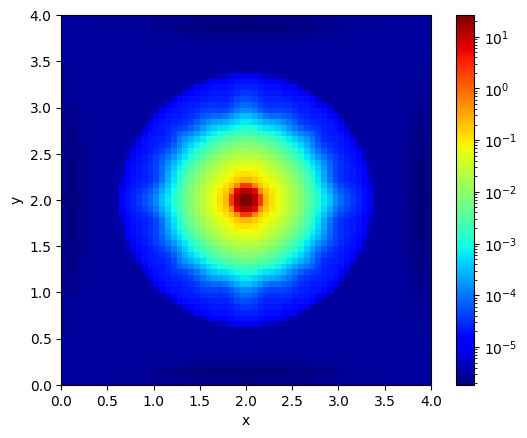

In [6]:
from matplotlib.colors import LogNorm

a = num_cells // 2 - 10
b = num_cells // 2 + 10

plt.imshow(final_state[registered_variables.pressure_index, :, :, num_cells // 2].T, cmap = "jet", origin = "lower", extent=[0, box_size, 0, box_size], norm = LogNorm())
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")

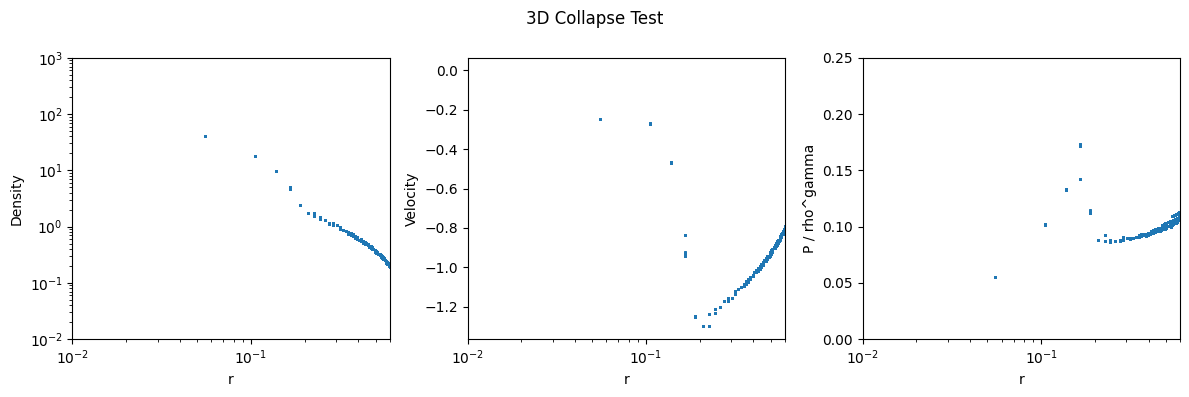

In [7]:
# plot the radial density profile rho over r in a log-log plot

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

ax1.scatter(helper_data.r.flatten(), final_state[registered_variables.density_index].flatten(), label="Final Density", s = 1)
# x and y log scale
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.set_xlim(1e-2, 6e-1)
ax1.set_ylim(1e-2, 1e3)
ax1.set_xlabel("r")
ax1.set_ylabel("Density")

# velocity profile
v_r = -jnp.sqrt(final_state[registered_variables.velocity_index.x] ** 2 + final_state[registered_variables.velocity_index.y] ** 2 + final_state[registered_variables.velocity_index.z] ** 2)

ax2.scatter(helper_data.r.flatten(), v_r.flatten(), label="Radial Velocity", s = 1)
# log x scale
ax2.set_xscale("log")
ax2.set_xlim(1e-2, 6e-1)
ax2.set_xlabel("r")
ax2.set_ylabel("Velocity")

# plot P / rho^gamma

ax3.scatter(helper_data.r.flatten(), final_state[registered_variables.pressure_index].flatten() / final_state[registered_variables.density_index].flatten() ** gamma, label="P / rho^gamma", s = 1)
ax3.set_xlim(box_size / num_cells, 6e-1)
ax3.set_xlabel("r")
ax3.set_ylabel("P / rho^gamma")
ax3.set_xscale("log")
ax3.set_ylim(0, 0.25)
ax3.set_xlim(1e-2, 6e-1)

fig.suptitle("3D Collapse Test")

plt.tight_layout()

## Conservational properties

In [8]:
config = config._replace(return_snapshots = True, num_snapshots = 60)
params = params._replace(t_end = 3.0)

snapshots = time_integration(initial_state, config, params, helper_data, registered_variables)

In [9]:
total_energy = snapshots.total_energy
internal_energy = snapshots.internal_energy
kinetic_energy = snapshots.kinetic_energy
gravitational_energy = snapshots.gravitational_energy
total_mass = snapshots.total_mass
time = snapshots.time_points

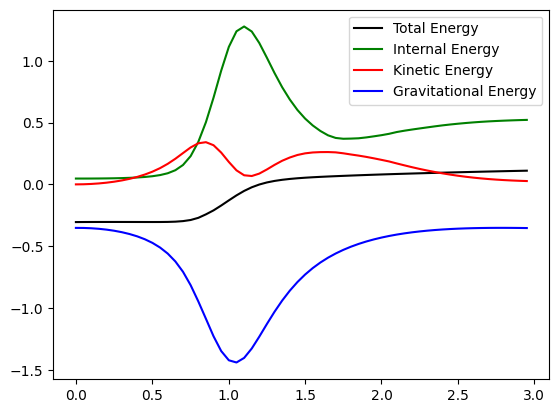

In [10]:
t_end = 3.0
plt.plot(time, total_energy, label="Total Energy", color = "black")
plt.plot(time, internal_energy, label="Internal Energy", color = "green")
plt.plot(time, kinetic_energy, label="Kinetic Energy", color = "red")
plt.plot(time, gravitational_energy, label="Gravitational Energy", color = "blue")#
plt.legend()

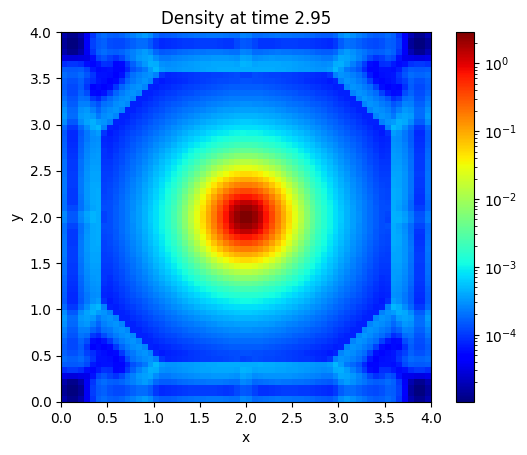

In [11]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

def animate(i):
    ax.clear()
    state = snapshots.states[i]
    im = ax.imshow(state[0, :, :, num_cells // 2].T, cmap="jet", origin="lower", extent=[0, box_size, 0, box_size], norm=LogNorm())
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"Density at time {time[i]:.2f}")
    return [im]

ani = animation.FuncAnimation(fig, animate, frames=len(snapshots.states), interval=100, blit=True)
plt.colorbar(ax.imshow(snapshots.states[0][0, :, :, num_cells // 2].T, cmap="jet", origin="lower", extent=[0, box_size, 0, box_size], norm=LogNorm()), ax=ax)
# save to gif
ani.save("3d_collapse.gif")